# DSE220 Final Data Preprocessing Notebook

In [1]:
import gzip
from collections import defaultdict, Counter
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import pca
from sklearn.metrics import mean_absolute_error
%matplotlib inline

### read files

In [2]:
# read files
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

orig_train_df = getDF('train.json.gz')
orig_test_df = getDF('test_Helpful.json.gz')

In [3]:
print(orig_train_df.shape, orig_test_df.shape)

# split outOf and nHelpful out as separate columns
train_outOf = np.array([x['outOf'] for x in orig_train_df.helpful.values])
train_nHelpful = np.array([x['nHelpful'] for x in orig_train_df.helpful.values])
orig_train_df['outOf'] = train_outOf
orig_train_df['nHelpful'] = train_nHelpful
orig_train_df['pctHelpful'] = train_nHelpful / train_outOf

test_outOf = np.array([x['outOf'] for x in orig_test_df.helpful.values])
orig_test_df['outOf'] = test_outOf

(200000, 12) (14000, 12)


/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


In [4]:
train_df = orig_train_df
test_df = orig_test_df

In [5]:
train_df.head(2)

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price,outOf,nHelpful,pctHelpful
0,0,"[[Clothing, Shoes & Jewelry, Women], [Clothing...",I655355328,U745881038,3.0,"These are cute, but they are a little small. ...",R115160670,"05 20, 2014",Cute,1400544000,"{'outOf': 0, 'nHelpful': 0}",NaN,0,0,NaN
1,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I241092314,U023577405,4.0,"I love the look of this bra, it is what I want...",R800651687,"02 7, 2013",Beautiful but size runs small,1360195200,"{'outOf': 0, 'nHelpful': 0}",NaN,0,0,NaN


### split training data into train, val, test set

In [6]:
test_df.shape[0] / train_df.shape[0]

0.07

In [7]:
X_train_orig, X_val_orig = train_test_split(train_df, test_size=0.20, random_state=55)
X_train = X_train_orig
X_val = X_val_orig

print(X_train.shape, X_val.shape)

(160000, 15) (40000, 15)


In [8]:
X_train.loc[(X_train.outOf > 80) & (X_train.pctHelpful < 0.2),:]

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price,outOf,nHelpful,pctHelpful
166126,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I396699099,U823592738,4.0,Greetings fellow amazonians I picked these up ...,R350929977,"10 1, 2012",thought they would help me wrestle bears,1349049600,"{'outOf': 88, 'nHelpful': 12}",59.95,88,12,0.136364


In [ ]:
# drop outlier rows - see EDA notebook
outlier_train_idx = X_train.loc[(X_train.outOf > 80) & (X_train.pctHelpful < 0.2),:].index.values
print(X_train.shape)
X_train = X_train.drop(outlier_train_idx)
print(X_train.shape)

In [ ]:
X_val.head()

### comparison of train, validation, and test sets

###### number of reviewers and reviewers in common

In [9]:
train_revIDs = set(X_train.reviewerID.values)
val_revIDs = set(X_val.reviewerID.values)
test_revIDs = set(test_df.reviewerID.values)

print(len(train_revIDs))
print(len(val_revIDs))
print(len(test_revIDs))
print(len(train_revIDs.intersection(val_revIDs)))
print(len(train_revIDs.intersection(test_revIDs)))

38885
24796
11632
24432
11455


###### number of items in common

In [10]:
train_itemIDs = set(X_train.itemID.values)
val_itemIDs = set(X_val.itemID.values)
test_itemIDs = set(test_df.itemID.values)

print(len(train_itemIDs))
print(len(val_itemIDs))
print(len(test_itemIDs))
print(len(train_itemIDs.intersection(val_itemIDs)))
print(len(train_itemIDs.intersection(test_itemIDs)))

19885
15336
8672
15308
8654


##### number of each rating

[ 0.58066875  0.2102375   0.11176875  0.057625    0.0397    ]


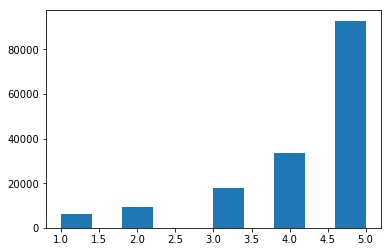

In [11]:
train_ratings = np.array(X_train.rating.value_counts()) / X_train.shape[0] * 1.0
print(train_ratings)
plt.hist(X_train.rating.values);

[ 0.578175  0.21245   0.1115    0.0567    0.041175]


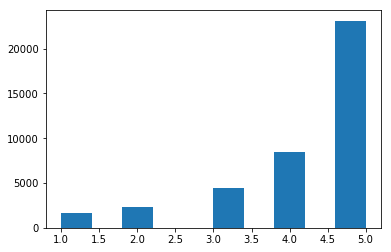

In [12]:
val_ratings = np.array(X_val.rating.value_counts()) / X_val.shape[0] * 1.0
print(val_ratings)
plt.hist(X_val.rating.values);

[ 0.57864286  0.21242857  0.11178571  0.05771429  0.03942857]


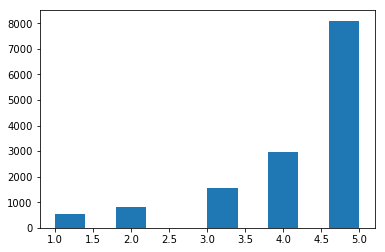

In [13]:
test_ratings = np.array(test_df.rating.value_counts()) / test_df.shape[0] * 1.0
print(test_ratings)
plt.hist(test_df.rating.values);

### add review based features

###### total number of reviews for each user and item

In [14]:
# total number of reviews for each user
allUserReviewCounts = X_train.reviewerID.value_counts()

reviewerIDs = np.array(allUserReviewCounts.index)
numUserReviews = np.array(allUserReviewCounts.values)

allUserReviewCountsDF = pd.DataFrame({'reviewerID':reviewerIDs,'userTotReviews':numUserReviews})

X_train = pd.merge(X_train, allUserReviewCountsDF, how='left', on='reviewerID')

In [15]:
#test_df.userTotReviews.isnull().sum()

In [16]:
# total number of reviews for each item
allItemReviewCounts = X_train.itemID.value_counts()

itemIDs = np.array(allItemReviewCounts.index)
numItemReviews = np.array(allItemReviewCounts.values)

allItemReviewCountsDF = pd.DataFrame({'itemID':itemIDs,'itemTotReviews':numItemReviews})

X_train = pd.merge(X_train, allItemReviewCountsDF, how='left', on='itemID')

###### average helpfulness rating by user and item

In [17]:
# global usefulness rate and user and item-specific usefulness rate - from baseline model
allHelpful = []
userHelpful = defaultdict(list)
itemHelpful = defaultdict(list)

for idx in X_train.index:
  user,item = X_train.loc[idx,'reviewerID'],X_train.loc[idx,'itemID']
  allHelpful.append(X_train.loc[idx,'helpful'])
  userHelpful[user].append(X_train.loc[idx,'helpful'])
  itemHelpful[item].append(X_train.loc[idx,'helpful'])

In [18]:
averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
userRate = {}

users = []
uHelpfulRates = []

for u in userHelpful:
  totalU = sum([x['outOf'] for x in userHelpful[u]])
  users.append(u)
  if totalU > 0:
    uHelpful = sum([x['nHelpful'] for x in userHelpful[u]]) * 1.0 / totalU
    userRate[u] = uHelpful
    uHelpfulRates.append(uHelpful)
  else:
    userRate[u] = averageRate
    uHelpfulRates.append(averageRate)

In [19]:
userHelpfulnessDF = pd.DataFrame({'reviewerID':users,'avgUserHelpfulness':uHelpfulRates})

In [20]:
itemRate = {}

items = []
iHelpfulRates = []

for i in itemHelpful:
  totalI = sum([x['outOf'] for x in itemHelpful[i]])
  items.append(i)
  if totalI > 0:
    iHelpful = sum([x['nHelpful'] for x in itemHelpful[i]]) * 1.0 / totalI
    itemRate[i] = iHelpful
    iHelpfulRates.append(iHelpful)
  else:
    userRate[u] = averageRate
    iHelpfulRates.append(averageRate)

In [21]:
itemHelpfulnessDF = pd.DataFrame({'itemID':items,'avgItemHelpfulness':iHelpfulRates})

In [22]:
X_train = pd.merge(X_train, userHelpfulnessDF, how='left', on='reviewerID')
X_train = pd.merge(X_train, itemHelpfulnessDF, how='left', on='itemID')

In [23]:
X_train.head()

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price,outOf,nHelpful,pctHelpful,userTotReviews,itemTotReviews,avgUserHelpfulness,avgItemHelpfulness
0,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I630927268,U257632100,5.0,I was looking for simple soft anklets that wer...,R560860044,"04 3, 2014",Nice,1396483200,"{'outOf': 0, 'nHelpful': 0}",11.99,0,0,NaN,6,52,0.777778,0.950820
1,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I500768895,U021132998,4.0,These LifeStride Women's Debate Ballet Flat ar...,R243188867,"06 19, 2012","Fantastic, runs about 1/2 size long",1340064000,"{'outOf': 4, 'nHelpful': 4}",NaN,4,4,1.0,17,13,0.932432,0.800000
2,0,"[[Clothing, Shoes & Jewelry, Women, Shoes, Sli...",I116118671,U438893887,5.0,I bought this for my mom and she is very happy...,R390173868,"11 13, 2013",cute,1384300800,"{'outOf': 0, 'nHelpful': 0}",NaN,0,0,NaN,4,11,1.000000,0.853664
3,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I236846975,U383324180,5.0,Love these sandals. The color is nice and the ...,R972889244,"07 11, 2013",Fit and feel great,1373500800,"{'outOf': 0, 'nHelpful': 0}",NaN,0,0,NaN,3,25,0.853664,0.888889
4,1,"[[Sports & Outdoors, Clothing, Men, Shorts, Co...",I348700499,U141921993,4.0,I love Under Armour. Some people might say it'...,R909388248,"02 20, 2014",Great compression gear,1392854400,"{'outOf': 0, 'nHelpful': 0}",24.99,0,0,NaN,5,13,0.853664,0.700000


### drop rows where 'outOf' is zero

In [24]:
X_train.shape

(160000, 19)

In [25]:
# keep only rows where outOf is nonzero
X_train['outOf'] = np.array([x['outOf'] for x in X_train.helpful.values])
X_train = X_train[X_train.outOf > 0]

In [26]:
X_train.shape

(50530, 19)

###### number of rated reviews for each user and item

In [27]:
# number of rated reviews for each user
ratedUserReviewCounts = X_train.loc[X_train['outOf']>0,'reviewerID'].value_counts()

reviewerIDs = np.array(ratedUserReviewCounts.index)
numUserReviews = np.array(ratedUserReviewCounts.values)

ratedUserReviewCountsDF = pd.DataFrame({'reviewerID':reviewerIDs,'userRatedReviews':numUserReviews})

X_train = pd.merge(X_train, ratedUserReviewCountsDF, how='left', on='reviewerID')

In [28]:
# number of rated reviews for each item
ratedItemReviewCounts = X_train.loc[X_train['outOf']>0,'itemID'].value_counts()

itemIDs = np.array(ratedItemReviewCounts.index)
numItemReviews = np.array(ratedItemReviewCounts.values)

ratedItemReviewCountsDF = pd.DataFrame({'itemID':itemIDs,'itemRatedReviews':numItemReviews})

X_train = pd.merge(X_train, ratedItemReviewCountsDF, how='left', on='itemID')

###### percentage of reviews with ratings by user and item

In [29]:
X_train['pctUserReviewsRated'] = X_train.userRatedReviews.values / X_train.userTotReviews.values
X_train['pctItemReviewsRated'] = X_train.itemRatedReviews.values / X_train.itemTotReviews.values

In [30]:
X_train.head()

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,...,nHelpful,pctHelpful,userTotReviews,itemTotReviews,avgUserHelpfulness,avgItemHelpfulness,userRatedReviews,itemRatedReviews,pctUserReviewsRated,pctItemReviewsRated
0,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I500768895,U021132998,4.0,These LifeStride Women's Debate Ballet Flat ar...,R243188867,"06 19, 2012","Fantastic, runs about 1/2 size long",1340064000,...,4,1.0,17,13,0.932432,0.800000,9,5,0.529412,0.384615
1,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I243311479,U482369528,4.0,This item was very elegant. Received a lot of...,R861586443,"02 17, 2014",Love butterflies,1392595200,...,2,1.0,3,7,0.750000,1.000000,2,1,0.666667,0.142857
2,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I496891609,U737837172,5.0,This top fit so great and made my figure pop f...,R354381202,"09 8, 2013",Pretty and comfortabe,1378598400,...,7,1.0,7,23,0.913043,0.958333,5,9,0.714286,0.391304
3,1,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I725702722,U866103305,5.0,I was looking for a shoe that I could slip on ...,R108223910,"06 4, 2013",Great Crocs!,1370304000,...,1,0.5,1,5,0.500000,0.500000,1,1,1.000000,0.200000
4,1,"[[Clothing, Shoes & Jewelry, Men, Accessories,...",I716842709,U701505038,5.0,I typically do not carry a purse and big walle...,R682480065,"10 15, 2013",Holds just enough,1381795200,...,1,1.0,4,32,1.000000,0.500000,3,2,0.750000,0.062500


### split out 'nHelpful' and 'outOf' as separate columns and add 'pctHelpful'

In [ ]:
# split out nHelpful and outOf as separate columns
#outOf = np.array([x['outOf'] for x in X_train.helpful.values])
#nHelpful = np.array([x['nHelpful'] for x in X_train.helpful.values])
#X_train['outOf'] = outOf
#X_train['nHelpful'] = nHelpful

In [ ]:
#X_train['pctHelpful'] = nHelpful/outOf

In [ ]:
#X_train.head(2)

### add category features

###### number of categories each item is in

In [31]:
X_train.loc[X_train['outOf']>0,['itemID','reviewerID','categories']]

,itemID,reviewerID,categories
0,I500768895,U021132998,"[[Clothing, Shoes & Jewelry, Shoes & Accessori..."
1,I243311479,U482369528,"[[Clothing, Shoes & Jewelry, Women, Accessorie..."
2,I496891609,U737837172,"[[Clothing, Shoes & Jewelry, Women, Clothing, ..."
3,I725702722,U866103305,"[[Clothing, Shoes & Jewelry, Shoes & Accessori..."
4,I716842709,U701505038,"[[Clothing, Shoes & Jewelry, Men, Accessories,..."
5,I344988846,U155876049,"[[Sports & Outdoors, Boating & Water Sports, S..."
6,I252283842,U912421701,"[[Clothing, Shoes & Jewelry, Men, Accessories,..."
7,I251011959,U354969495,"[[Clothing, Shoes & Jewelry, Shoes & Accessori..."
8,I642720727,U496856203,"[[Clothing, Shoes & Jewelry, Men, Clothing, Un..."
9,I881783337,U980741595,"[[Sports & Outdoors, Clothing, Women, Shirts, ..."


In [32]:
categories = X_train.categories.values
numCategories = list(map(lambda l: len(l), categories))

X_train['numCategories'] = numCategories

In [33]:
# check result for specified row
k = 0
categories[k], numCategories[k]

([['Clothing, Shoes & Jewelry',
   'Shoes & Accessories: International Shipping Available'],
  ['Clothing, Shoes & Jewelry', 'L', 'LifeStride'],
  ['Clothing, Shoes & Jewelry', 'Women', 'Shoes', 'Flats']],
 3)

In [34]:
categories_outOfPos = X_train.loc[X_train['outOf']>0,'categories'].values
categories_all = X_train.categories.values

categories_set = set()
categories_tup = []

for cat_list in categories_outOfPos:
    for cat in cat_list:
        categories_set.add(tuple(cat))
        categories_tup.append(tuple(cat))

print(len(categories_set))

1753


In [35]:
len(list(categories_tup))

122784

In [36]:
# helper function to flatten a list one level
def flatten_one(z):
    return [x for y in z for x in y]

In [37]:
cat_group_counts = Counter(categories_tup)
cat_group_counts.most_common(10)

[(('Clothing, Shoes & Jewelry',
   'Shoes & Accessories: International Shipping Available'),
  9740),
 (('Clothing, Shoes & Jewelry', 'Women'), 4739),
 (('Clothing, Shoes & Jewelry', 'Comfort Shoes'), 3454),
 (('Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Novelty'), 2732),
 (('Clothing, Shoes & Jewelry', 'Jewelry: International Shipping Available'),
  2602),
 (('Clothing, Shoes & Jewelry', 'Women', 'Shoes', 'Sandals'), 2284),
 (('Clothing, Shoes & Jewelry', 'Women', 'Shoes', 'Boots'), 2088),
 (('Clothing, Shoes & Jewelry', 'Men', 'Big & Tall'), 1981),
 (('Clothing, Shoes & Jewelry',
   'Women',
   'Clothing',
   'Lingerie, Sleep & Lounge',
   'Intimates',
   'Bras',
   'Everyday Bras'),
  1935),
 (('Clothing, Shoes & Jewelry',
   'Women',
   'Clothing',
   'Tops & Tees',
   'Blouses & Button-Down Shirts'),
  1490)]

In [38]:
# convert nested list of categories to a single list of individual category labels for each row,
# use set to remove duplicates within each row
catfl = []
for c in categories_outOfPos:
    catfl.append(list(set(flatten_one(c))))

catfl

[['Shoes',
  'Flats',
  'LifeStride',
  'Clothing, Shoes & Jewelry',
  'Shoes & Accessories: International Shipping Available',
  'L',
  'Women'],
 ['Fashion Scarves',
  'Scarves & Wraps',
  'Clothing, Shoes & Jewelry',
  'Accessories',
  'Women'],
 ['Women',
  'Clothing',
  'Tops & Tees',
  'Clothing, Shoes & Jewelry',
  'Blouses & Button-Down Shirts'],
 ['Shoes',
  'Men',
  'Comfort Shoes',
  'crocs',
  'Mules & Clogs',
  'Clothing, Shoes & Jewelry',
  'Shoes & Accessories: International Shipping Available',
  'C'],
 ['Men',
  'Novelty, Costumes & More',
  'Band & Music Fan',
  'Wallets',
  'Clothing, Shoes & Jewelry',
  'Accessories',
  'Wallets, Card Cases & Money Organizers'],
 ['Men',
  'Swimming',
  'Clothing, Shoes & Jewelry',
  'Boating & Water Sports',
  'Sports & Outdoors',
  'Swimwear',
  'Jammers'],
 ['Men',
  'Sunglasses & Eyewear Accessories',
  'Clothing, Shoes & Jewelry',
  'Sunglasses',
  'Accessories'],
 ['Shoes',
  'Clothing, Shoes & Jewelry',
  'Slippers',
  'Shoes

In [39]:
# flatten list of lists to get single list
catflat = flatten_one(catfl)
catflat

['Shoes',
 'Flats',
 'LifeStride',
 'Clothing, Shoes & Jewelry',
 'Shoes & Accessories: International Shipping Available',
 'L',
 'Women',
 'Fashion Scarves',
 'Scarves & Wraps',
 'Clothing, Shoes & Jewelry',
 'Accessories',
 'Women',
 'Women',
 'Clothing',
 'Tops & Tees',
 'Clothing, Shoes & Jewelry',
 'Blouses & Button-Down Shirts',
 'Shoes',
 'Men',
 'Comfort Shoes',
 'crocs',
 'Mules & Clogs',
 'Clothing, Shoes & Jewelry',
 'Shoes & Accessories: International Shipping Available',
 'C',
 'Men',
 'Novelty, Costumes & More',
 'Band & Music Fan',
 'Wallets',
 'Clothing, Shoes & Jewelry',
 'Accessories',
 'Wallets, Card Cases & Money Organizers',
 'Men',
 'Swimming',
 'Clothing, Shoes & Jewelry',
 'Boating & Water Sports',
 'Sports & Outdoors',
 'Swimwear',
 'Jammers',
 'Men',
 'Sunglasses & Eyewear Accessories',
 'Clothing, Shoes & Jewelry',
 'Sunglasses',
 'Accessories',
 'Shoes',
 'Clothing, Shoes & Jewelry',
 'Slippers',
 'Shoes & Accessories: International Shipping Available',
 'E'

In [40]:
# determine top most common category labels from our data
num_cats_to_include = 200

cat_counts = Counter(catflat)
cat_counts.most_common(num_cats_to_include)

[('Clothing, Shoes & Jewelry', 50530),
 ('Women', 37985),
 ('Clothing', 24149),
 ('Shoes', 12476),
 ('Men', 11109),
 ('Shoes & Accessories: International Shipping Available', 9740),
 ('Novelty, Costumes & More', 9598),
 ('Novelty', 6989),
 ('Petite', 5673),
 ('Lingerie, Sleep & Lounge', 5338),
 ('Jewelry', 5264),
 ('Intimates', 4887),
 ('Accessories', 4394),
 ('Sports & Outdoors', 3899),
 ('Comfort Shoes', 3454),
 ('Tops & Tees', 3425),
 ('Plus-Size', 3170),
 ('Active', 2763),
 ('Athletic', 2645),
 ('Bras', 2617),
 ('Jewelry: International Shipping Available', 2602),
 ('Sandals', 2570),
 ('C', 2465),
 ('Big & Tall', 2445),
 ('Boots', 2367),
 ('Dresses', 2262),
 ('Everyday Bras', 2158),
 ('Casual', 2151),
 ('Watches', 2106),
 ('Wrist Watches', 2066),
 ('Fashion', 1773),
 ('Boot Shop', 1699),
 ('Earrings', 1623),
 ('Blouses & Button-Down Shirts', 1611),
 ('New Arrivals', 1604),
 ('S', 1590),
 ('Shirts', 1517),
 ('Fine', 1470),
 ('Amazon Curated Collection', 1404),
 ('Running', 1403),
 ('

In [41]:
# create list of top categories
top_cats_list = [x[0] for x in cat_counts.most_common(num_cats_to_include)]
top_cats_list

['Clothing, Shoes & Jewelry',
 'Women',
 'Clothing',
 'Shoes',
 'Men',
 'Shoes & Accessories: International Shipping Available',
 'Novelty, Costumes & More',
 'Novelty',
 'Petite',
 'Lingerie, Sleep & Lounge',
 'Jewelry',
 'Intimates',
 'Accessories',
 'Sports & Outdoors',
 'Comfort Shoes',
 'Tops & Tees',
 'Plus-Size',
 'Active',
 'Athletic',
 'Bras',
 'Jewelry: International Shipping Available',
 'Sandals',
 'C',
 'Big & Tall',
 'Boots',
 'Dresses',
 'Everyday Bras',
 'Casual',
 'Watches',
 'Wrist Watches',
 'Fashion',
 'Boot Shop',
 'Earrings',
 'Blouses & Button-Down Shirts',
 'New Arrivals',
 'S',
 'Shirts',
 'Fine',
 'Amazon Curated Collection',
 'Running',
 'Pants',
 'N',
 'Jeans',
 'D',
 'Handbags & Wallets',
 'Available for International Shipping',
 'Panties',
 'Underwear',
 'Flats',
 'Socks',
 'Exotic Apparel',
 'Sleep & Lounge',
 'T-Shirts',
 'Leggings',
 'Band & Music Fan',
 'Necklaces & Pendants',
 'Loafers & Slip-Ons',
 'Fashion Watches',
 'Clarks',
 'Rings',
 'Socks & Ho

In [42]:
# create table to indicate to which categories each reviewed item belong
catTable = np.zeros((X_train.shape[0],len(top_cats_list)))

catfl_all = []
for c in categories_all:
    catfl_all.append(list(set(flatten_one(c))))

catfl

for row in range(X_train.shape[0]):
    item_cats = catfl[row]
    for col in range(len(top_cats_list)):
        cat = top_cats_list[col]
        if cat in item_cats:
            catTable[row,col] = 1.0
        else:
            pass

In [43]:
# check that column sums add to actual counts of individual categories
catTable.sum(axis=0)

array([ 50530.,  37985.,  24149.,  12476.,  11109.,   9740.,   9598.,
         6989.,   5673.,   5338.,   5264.,   4887.,   4394.,   3899.,
         3454.,   3425.,   3170.,   2763.,   2645.,   2617.,   2602.,
         2570.,   2465.,   2445.,   2367.,   2262.,   2158.,   2151.,
         2106.,   2066.,   1773.,   1699.,   1623.,   1611.,   1604.,
         1590.,   1517.,   1470.,   1404.,   1403.,   1291.,   1289.,
         1243.,   1128.,   1095.,   1093.,   1091.,   1072.,    964.,
          897.,    897.,    897.,    888.,    874.,    869.,    861.,
          860.,    811.,    795.,    791.,    784.,    771.,    763.,
          762.,    757.,    738.,    731.,    715.,    708.,    704.,
          702.,    701.,    680.,    670.,    648.,    636.,    632.,
          629.,    628.,    625.,    614.,    613.,    588.,    582.,
          576.,    576.,    564.,    557.,    556.,    551.,    550.,
          536.,    533.,    532.,    530.,    518.,    514.,    501.,
          498.,    4

In [44]:
# create dataframe of top category indicators for each item review
cat_labels = ['category_' + cat for cat in top_cats_list]

topCatDF = pd.DataFrame(catTable, index=X_train.reviewHash, columns=cat_labels)
print(topCatDF.shape)
topCatDF.head()

(50530, 200)


,"category_Clothing, Shoes & Jewelry",category_Women,category_Clothing,category_Shoes,category_Men,category_Shoes & Accessories: International Shipping Available,"category_Novelty, Costumes & More",category_Novelty,category_Petite,"category_Lingerie, Sleep & Lounge",...,category_Active Leggings,category_Watch Accessories,category_Dress Shirts,category_Bella,category_Polos,category_Tights,category_Fashion Hoodies & Sweatshirts,category_Dansko,category_Tights & Leggings,category_Reebok
reviewHash,,,,,,,,,,,,,,,,,,,,,
R243188867,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R861586443,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R354381202,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R108223910,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R682480065,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# merge top category data frame into main data frame
X_train = pd.merge(X_train, topCatDF, how='left', left_on='reviewHash', right_index=True)
X_train.head(2)

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,...,category_Active Leggings,category_Watch Accessories,category_Dress Shirts,category_Bella,category_Polos,category_Tights,category_Fashion Hoodies & Sweatshirts,category_Dansko,category_Tights & Leggings,category_Reebok
0,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I500768895,U021132998,4.0,These LifeStride Women's Debate Ballet Flat ar...,R243188867,"06 19, 2012","Fantastic, runs about 1/2 size long",1340064000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I243311479,U482369528,4.0,This item was very elegant. Received a lot of...,R861586443,"02 17, 2014",Love butterflies,1392595200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### add text features

In [46]:
# extract review text
X_train_txt = np.array(X_train.reviewText.values)
X_train_sum = np.array(X_train.summary.values)



In [47]:
# review text with punctuation removed
noPunct = str.maketrans({key: None for key in string.punctuation})
X_train_txt_no_punct = np.array([t.translate(noPunct) for t in X_train_txt])
X_train_sum_no_punct = np.array([t.translate(noPunct) for t in X_train_sum])


##### review text length

In [48]:
# calculate number of word tokens after removing punctuation
X_train_txtNumWords = np.array([len(word_tokenize(t)) for t in X_train_txt_no_punct])
X_train_sumNumWords = np.array([len(word_tokenize(t)) for t in X_train_sum_no_punct])

X_train['reviewTextNumWords'] = X_train_txtNumWords
X_train['summaryTextNumWords'] = X_train_sumNumWords


In [49]:
# check random review length result
k = 18
print(X_train_txtNumWords[k],X_train_txt[k])



57 The 0-6 month size is way too big for my 7 week old, but it still does the trick if adjusted and tied right.  I love the fact that it has a very wide/long visor part (fabric not stiff) and the long extended fabric in the back to shield her neck.  A very nice baby sun hat.


###### number of sentences

In [50]:
X_train_txtNumSentences = np.array([len(sent_tokenize(t)) for t in X_train_txt])

X_train['reviewTextNumSents'] = X_train_txtNumSentences

In [51]:
# check random row - ellipses?
k = 5
print(X_train_txtNumSentences[k],X_train_txt[k])

3 i have been using TYR products for some time now, and these are 'high quality' just like the rest of the TYR products. i have these as well as the jammer-length suits as well. i prefer these more now as they don't seem to stretch as much as the jammers do as a result of exposure to chlorine.


###### review text readability score

based on Flesch Reading Ease Score (FRES) and Flesch-Kincaid Grade Level Formula - see https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests

number of syllable calculation based on info from CMU pronunciation dictionary - see http://www.speech.cs.cmu.edu/cgi-bin/cmudict

for number of syllable calculation code - see https://datawarrior.wordpress.com/2016/03/29/flesch-kincaid-readability-measure/

In [52]:
from nltk.corpus import cmudict
prondict = cmudict.dict()

In [53]:
# helper function to determine number of syllables
numsyllables_pronlist = lambda l: len(list(filter(lambda s: (s.lower()[-1]).isdigit(), l)))
def numsyllables(word):
  try:
    return list(set(map(numsyllables_pronlist, prondict[word.lower()])))
  except KeyError:
    return [0]

In [54]:
X_train_txtNumSyllabs = np.array([sum(map(lambda w: max(numsyllables(w)), word_tokenize(t))) for t in X_train_txt_no_punct])

In [55]:
flesch_formula = lambda word_count, sent_count, syllable_count : 206.835 - 1.015*word_count/sent_count - 84.6*syllable_count/word_count
fk_formula = lambda word_count, sent_count, syllable_count : 0.39 * word_count / sent_count + 11.8 * syllable_count / word_count - 15.59

X_train_txtReadF = flesch_formula(X_train_txtNumWords, X_train_txtNumSentences, X_train_txtNumSyllabs)
X_train_txtReadFK = fk_formula(X_train_txtNumWords, X_train_txtNumSentences, X_train_txtNumSyllabs)

X_train['reviewTextFscore'] = X_train_txtReadF
X_train['reviewTextFKscore'] = X_train_txtReadFK

In [56]:
# check random row
k = 20
print(X_train_txtNumSyllabs[k],X_train_txtReadF[k],X_train_txtReadFK[k],X_train_txt[k])

620 69.9752358491 10.0825262055 This is a really nice Passcase Style Wallet, which is my personal preferred style. It looks great, has plenty of room for my stuff, actually takes up less space in my pocket than the seemingly smaller wallet it replaced, and appears very well made. Of course only time will tell how it actually holds up, so if you see this review is the same after like 2 years you know this was a really excellent product. Don't buy this to replace a really slim billfold wallet like the TUMI I previously reviewed (its huge compared to that), and personally I also keep my wallet in my front pocket so I have no idea how this is to sit on, but its my personal favorite wallet I've ever held. It's reasonably soft, yet it feels really tough at the same time, and I love the heat pressed logo, the pebble grain finish, the contrast stitching, and especially the rivets. As long as this holds up (which I expect it to), I would definitely look at Carhartt for a wallet again. In fact i

###### percentage of words in all caps

In [57]:
# calculate number of words that are non-numeric and length > 1 that are all caps
X_train_txtNumCapsWords = np.array([len([t for t in word_tokenize(t) if 
                                 (t.isalpha() and len(t)>1 and t == t.upper())]) 
                            for t in X_train_txt_no_punct])

X_train_sumNumCapsWords = np.array([len([t for t in word_tokenize(t) if 
                                 (t.isalpha() and len(t)>1 and t == t.upper())]) 
                            for t in X_train_sum_no_punct])


In [58]:
X_train_txtPctWordsAllCaps = X_train_txtNumCapsWords/X_train_txtNumWords
X_train_sumPctWordsAllCaps = X_train_sumNumCapsWords/X_train_sumNumWords

X_train['reviewTextPctWordsAllCaps'] = X_train_txtPctWordsAllCaps
X_train['summaryTextPctWordsAllCaps'] = X_train_sumPctWordsAllCaps


/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [59]:
# check random row
k = 202
print(X_train_txtPctWordsAllCaps[k],X_train_txtNumCapsWords[k],X_train_txt[k])

0.0 0 I thought it may be on the small side being hand made so I got a 2x. It would probably fit a size 20 to 22 It doesn't grab at any problem areas. The sleeves are roomy the colors are amazing. It is well made and I will be buying more. I like that it fits large I am 5'10 and it is hard to find one to cover all this. lol But it is long enough to wear with leggings or fitted capris.


###### percentage of sentences in all caps

In [60]:
# calculate number of sentences that are not entirely punctuation and are all caps
X_train_txtNumCapsSents = np.array([len([s for s in sent_tokenize(t) 
                                 if s == s.upper() and s.translate(noPunct) != '']) 
                            for t in X_train_txt])

In [61]:
X_train_txtPctSentsAllCaps = X_train_txtNumCapsSents/X_train_txtNumSentences

X_train['reviewTextPctSentsAllCaps'] = X_train_txtPctSentsAllCaps

In [62]:
# check random row
k = 301
print(X_train_txtPctSentsAllCaps[k],X_train_txt[k])

0.166666666667 I have been wearing Spanx Higher Power for years and I love them. They tuck the tummy, lift the booty, and smooth the thighs. I am seriously disappointed, however, that they no longer have the silicone strip around the top band. Because that is no longer there, it slides down and makes a gross bunching of fat on my back. If I wear my hair down or wear a jacket, it's ok...but I have to keep yanking it up. BRING BACK THE SILICONE STRIP!


###### percentage of capital letters

In [63]:
X_train_txttot_letters = np.array([sum(1 for c in t if c in string.ascii_letters) for t in X_train_txt])
X_train_txtcap_letters = np.array([sum(1 for c in t if c in string.ascii_uppercase) for t in X_train_txt])

X_train_sumtot_letters = np.array([sum(1 for c in t if c in string.ascii_letters) for t in X_train_sum])
X_train_sumcap_letters = np.array([sum(1 for c in t if c in string.ascii_uppercase) for t in X_train_sum])




In [64]:
# replace 0 values with 1 to prevent divide by 0 errors
X_train_txttot_letters[X_train_txttot_letters == 0] = 1
X_train_txttxtPctCapLetters = X_train_txtcap_letters/X_train_txttot_letters

X_train_sumtot_letters[X_train_sumtot_letters == 0] = 1
X_train_sumtxtPctCapLetters = X_train_sumcap_letters/X_train_sumtot_letters

X_train['reviewTxtPctCapsLetters'] = X_train_txttxtPctCapLetters
X_train['summaryTxtPctCapsLetters'] = X_train_sumtxtPctCapLetters


In [65]:
# check random row
k = 101
print(X_train_txttxtPctCapLetters[k],X_train_txt[k])



0.0306513409962 I'm a young man (under 30 years old), so I like to wear slim fit. I'm 5'7 and weigh 140 lbs and size 30x30 fits me perfectly. The material is nice, not too thick, not too thin, not too tough, not to soft. I feel like it's a combination of Jeans and silky Pants. Very suitable to wear to casual and semi-formal occasions like work, church and graduate school.


##### percentage of total characters in review that are punctuation

In [66]:
X_train_txtNumPunct = np.array([sum(1 for c in t if c in string.punctuation) for t in X_train_txt])
X_train_txtNumChars = np.array([len(t) for t in X_train_txt])

X_train_sumNumPunct = np.array([sum(1 for c in t if c in string.punctuation) for t in X_train_sum])
X_train_sumNumChars = np.array([len(t) for t in X_train_sum])


In [67]:
X_train_txtPctPunct = X_train_txtNumPunct/X_train_txtNumChars
X_train['reviewTxtPctPunct'] = X_train_txtPctPunct

X_train_sumPctPunct = X_train_sumNumPunct/X_train_sumNumChars
X_train['summaryTxtPctPunct'] = X_train_sumPctPunct


In [68]:
# check random row
k = 3
print(X_train_txtPctPunct[k],X_train_txtNumPunct[k],X_train_txtNumChars[k],X_train_txt[k])

0.0182232346241 8 439 I was looking for a shoe that I could slip on and off while mowing and driving the tractor.  These exceeded my expectations.  The footbed has plenty of texture to keep my foot from slipping, even when getting wet.  The texture on the bottom is very aggressive as well.  I find that I can walk across my concrete garage while it is wet and not have my foot slip out in front of me.  The color is cool too!  I will probably buy another pair.


### check for null values in training data

In [69]:
X_train_nulls = pd.isnull(X_train).any()
X_train_nulls[X_train_nulls == True].index.values



array(['price', 'summaryTextPctWordsAllCaps'], dtype=object)

In [70]:
# fill null values
# fill null price values with -1
X_train.loc[:,'price'].fillna(-1, inplace=True)

# fill summaryTextPctWordsAllCaps with 0
X_train.loc[:,'summaryTextPctWordsAllCaps'].fillna(0, inplace=True)




In [71]:
# recheck for nulls
print('should be zero:',sum(pd.isnull(X_train).any().values))

should be zero: 0


In [76]:
print(X_train.shape)
X_train_orig.head()

(50530, 236)


,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,helpful,price,outOf,nHelpful,pctHelpful
33142,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I630927268,U257632100,5.0,I was looking for simple soft anklets that wer...,R560860044,"04 3, 2014",Nice,1396483200,"{'outOf': 0, 'nHelpful': 0}",11.99,0,0,NaN
188894,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I500768895,U021132998,4.0,These LifeStride Women's Debate Ballet Flat ar...,R243188867,"06 19, 2012","Fantastic, runs about 1/2 size long",1340064000,"{'outOf': 4, 'nHelpful': 4}",NaN,4,4,1.0
40307,0,"[[Clothing, Shoes & Jewelry, Women, Shoes, Sli...",I116118671,U438893887,5.0,I bought this for my mom and she is very happy...,R390173868,"11 13, 2013",cute,1384300800,"{'outOf': 0, 'nHelpful': 0}",NaN,0,0,NaN
148822,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I236846975,U383324180,5.0,Love these sandals. The color is nice and the ...,R972889244,"07 11, 2013",Fit and feel great,1373500800,"{'outOf': 0, 'nHelpful': 0}",NaN,0,0,NaN
20134,1,"[[Sports & Outdoors, Clothing, Men, Shorts, Co...",I348700499,U141921993,4.0,I love Under Armour. Some people might say it'...,R909388248,"02 20, 2014",Great compression gear,1392854400,"{'outOf': 0, 'nHelpful': 0}",24.99,0,0,NaN


### Process Validation and Test Datasets

###### X_val

In [77]:
# preprocessing X_val
X_val = pd.merge(X_val, allUserReviewCountsDF, how='left', on='reviewerID')
X_val = pd.merge(X_val, allItemReviewCountsDF, how='left', on='itemID')

X_val = pd.merge(X_val, userHelpfulnessDF, how='left', on='reviewerID')
X_val = pd.merge(X_val, itemHelpfulnessDF, how='left', on='itemID')

# keep only rows where outOf is nonzero
X_val['outOf'] = np.array([x['outOf'] for x in X_val.helpful.values])
X_val = X_val[X_val.outOf > 0]
#X_val = X_val.drop('outOf', axis=1)

X_val = pd.merge(X_val, ratedUserReviewCountsDF, how='left', on='reviewerID')
X_val = pd.merge(X_val, ratedItemReviewCountsDF, how='left', on='itemID')
X_val['pctUserReviewsRated'] = X_val.userRatedReviews.values / X_val.userTotReviews.values
X_val['pctItemReviewsRated'] = X_val.itemRatedReviews.values / X_val.itemTotReviews.values

# split out nHelpful and outOf as separate columns
outOf = np.array([x['outOf'] for x in X_val.helpful.values])
nHelpful = np.array([x['nHelpful'] for x in X_val.helpful.values])
X_val['outOf'] = outOf
X_val['nHelpful'] = nHelpful
X_val['pctHelpful'] = nHelpful/outOf

categories = X_val.categories.values
numCategories = list(map(lambda l: len(l), categories))

X_val['numCategories'] = numCategories

# create table to indicate to which categories each reviewed item belong
catTable = np.zeros((X_val.shape[0],len(top_cats_list)))

for row in range(X_val.shape[0]):
    item_cats = catfl[row]
    for col in range(len(top_cats_list)):
        cat = top_cats_list[col]
        if cat in item_cats:
            catTable[row,col] = 1.0
        else:
            pass

topCatDF = pd.DataFrame(catTable, index=X_val.reviewHash, columns=cat_labels)
X_val = pd.merge(X_val, topCatDF, how='left', left_on='reviewHash', right_index=True)

# extract review text
X_val_txt = np.array(X_val.reviewText.values)
X_val_txt_no_punct = np.array([t.translate(noPunct) for t in X_val_txt])
X_val_sum = np.array(X_val.summary.values)
X_val_sum_no_punct = np.array([t.translate(noPunct) for t in X_val_sum])


X_val_txtNumWords = np.array([len(word_tokenize(t)) for t in X_val_txt_no_punct])
X_val['reviewTextNumWords'] = X_val_txtNumWords
X_val_sumNumWords = np.array([len(word_tokenize(t)) for t in X_val_sum_no_punct])
X_val['summaryTextNumWords'] = X_val_sumNumWords

X_val_txtNumSentences = np.array([len(sent_tokenize(t)) for t in X_val_txt])
X_val['reviewTextNumSents'] = X_val_txtNumSentences

X_val_txtNumSyllabs = np.array([sum(map(lambda w: max(numsyllables(w)), word_tokenize(t))) for t in X_val_txt_no_punct])
X_val_txtReadF = flesch_formula(X_val_txtNumWords, X_val_txtNumSentences, X_val_txtNumSyllabs)
X_val_txtReadFK = fk_formula(X_val_txtNumWords, X_val_txtNumSentences, X_val_txtNumSyllabs)

X_val['reviewTextFscore'] = X_val_txtReadF
X_val['reviewTextFKscore'] = X_val_txtReadFK

X_val_txtNumCapsWords = np.array([len([t for t in word_tokenize(t) if 
                                 (t.isalpha() and len(t)>1 and t == t.upper())]) 
                            for t in X_val_txt_no_punct])

X_val_txtPctWordsAllCaps = X_val_txtNumCapsWords/X_val_txtNumWords
X_val['reviewTextPctWordsAllCaps'] = X_val_txtPctWordsAllCaps

X_val_sumNumCapsWords = np.array([len([t for t in word_tokenize(t) if 
                                 (t.isalpha() and len(t)>1 and t == t.upper())]) 
                            for t in X_val_sum_no_punct])

X_val_sumPctWordsAllCaps = X_val_sumNumCapsWords/X_val_sumNumWords
X_val['summaryTextPctWordsAllCaps'] = X_val_sumPctWordsAllCaps

X_val_txtNumCapsSents = np.array([len([s for s in sent_tokenize(t) 
                                 if s == s.upper() and s.translate(noPunct) != '']) 
                            for t in X_val_txt])

X_val_txtPctSentsAllCaps = X_val_txtNumCapsSents/X_val_txtNumSentences
X_val['reviewTextPctSentsAllCaps'] = X_val_txtPctSentsAllCaps

X_val_tot_letters = np.array([sum(1 for c in t if c in string.ascii_letters) for t in X_val_txt])
X_val_cap_letters = np.array([sum(1 for c in t if c in string.ascii_uppercase) for t in X_val_txt])
X_val_tot_letters[X_val_tot_letters == 0] = 1
X_val_txtPctCapLetters = X_val_cap_letters/X_val_tot_letters
X_val['reviewTxtPctCapsLetters'] = X_val_txtPctCapLetters

X_val_sumtot_letters = np.array([sum(1 for c in t if c in string.ascii_letters) for t in X_val_sum])
X_val_sumcap_letters = np.array([sum(1 for c in t if c in string.ascii_uppercase) for t in X_val_sum])
X_val_sumtot_letters[X_val_sumtot_letters == 0] = 1
X_val_sumPctCapLetters = X_val_sumcap_letters/X_val_sumtot_letters
X_val['summaryTxtPctCapsLetters'] = X_val_sumPctCapLetters


X_val_txtNumPunct = np.array([sum(1 for c in t if c in string.punctuation) for t in X_val_txt])
X_val_txtNumChars = np.array([len(t) for t in X_val_txt])
X_val_txtPctPunct = X_val_txtNumPunct/X_val_txtNumChars
X_val['reviewTxtPctPunct'] = X_val_txtPctPunct

X_val_sumNumPunct = np.array([sum(1 for c in t if c in string.punctuation) for t in X_val_sum])
X_val_sumNumChars = np.array([len(t) for t in X_val_sum])
X_val_sumPctPunct = X_val_sumNumPunct/X_val_sumNumChars
X_val['summaryTxtPctPunct'] = X_val_sumPctPunct


/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in true_divide


###### check null values in validation dataset and fill

In [78]:
X_val_null = pd.isnull(X_val).any()
X_val_null[X_val_null == True].index.values

array(['price', 'userTotReviews', 'itemTotReviews', 'avgUserHelpfulness',
       'avgItemHelpfulness', 'userRatedReviews', 'itemRatedReviews',
       'pctUserReviewsRated', 'pctItemReviewsRated',
       'summaryTextPctWordsAllCaps'], dtype=object)

In [79]:
# fill nulls in num reviews with 0
X_val.loc[:,'userTotReviews'].fillna(0, inplace=True)
X_val.loc[:,'itemTotReviews'].fillna(0, inplace=True)
X_val.loc[:,'userRatedReviews'].fillna(0, inplace=True)
X_val.loc[:,'itemRatedReviews'].fillna(0, inplace=True)
X_val.loc[:,'pctUserReviewsRated'].fillna(0, inplace=True)
X_val.loc[:,'pctItemReviewsRated'].fillna(0, inplace=True)

# fill nulls in helpfulness ratings with average helpfulness rate
averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
X_val.loc[:,'avgUserHelpfulness'].fillna(averageRate, inplace=True)
X_val.loc[:,'avgItemHelpfulness'].fillna(averageRate, inplace=True)

# fill nulls in price with -1
X_val.loc[:,'price'].fillna(-1, inplace=True)

# fill nulls in summaryTextPctWordsAllCaps with 0
X_val.loc[:,'summaryTextPctWordsAllCaps'].fillna(0, inplace=True)


In [80]:
# recheck for nulls
print('should be zero:',sum(pd.isnull(X_val).any().values))

should be zero: 0


###### X_test

In [81]:
# set X_test equal to test_df
X_test = test_df

# preprocessing X_test
X_test = pd.merge(X_test, allUserReviewCountsDF, how='left', on='reviewerID')
X_test = pd.merge(X_test, allItemReviewCountsDF, how='left', on='itemID')

X_test = pd.merge(X_test, userHelpfulnessDF, how='left', on='reviewerID')
X_test = pd.merge(X_test, itemHelpfulnessDF, how='left', on='itemID')

# keep only rows where outOf is nonzero
X_test['outOf'] = np.array([x['outOf'] for x in X_test.helpful.values])
X_test = X_test[X_test.outOf > 0]
#X_test = X_test.drop('outOf', axis=1)

X_test = pd.merge(X_test, ratedUserReviewCountsDF, how='left', on='reviewerID')
X_test = pd.merge(X_test, ratedItemReviewCountsDF, how='left', on='itemID')
X_test['pctUserReviewsRated'] = X_test.userRatedReviews.values / X_test.userTotReviews.values
X_test['pctItemReviewsRated'] = X_test.itemRatedReviews.values / X_test.itemTotReviews.values

# split out nHelpful and outOf as separate columns
outOf = np.array([x['outOf'] for x in X_test.helpful.values])
X_test['outOf'] = outOf

categories = X_test.categories.values
numCategories = list(map(lambda l: len(l), categories))

X_test['numCategories'] = numCategories

# create table to indicate to which categories each reviewed item belong
catTable = np.zeros((X_test.shape[0],len(top_cats_list)))

for row in range(X_test.shape[0]):
    item_cats = catfl[row]
    for col in range(len(top_cats_list)):
        cat = top_cats_list[col]
        if cat in item_cats:
            catTable[row,col] = 1.0
        else:
            pass

topCatDF = pd.DataFrame(catTable, index=X_test.reviewHash, columns=cat_labels)
X_test = pd.merge(X_test, topCatDF, how='left', left_on='reviewHash', right_index=True)

# extract review text
X_test_txt = np.array(X_test.reviewText.values)
X_test_txt_no_punct = np.array([t.translate(noPunct) for t in X_test_txt])
X_test_sum = np.array(X_test.summary.values)
X_test_sum_no_punct = np.array([t.translate(noPunct) for t in X_test_sum])

X_test_txtNumWords = np.array([len(word_tokenize(t)) for t in X_test_txt_no_punct])
X_test['reviewTextNumWords'] = X_test_txtNumWords
X_test_sumNumWords = np.array([len(word_tokenize(t)) for t in X_test_sum_no_punct])
X_test['summaryTextNumWords'] = X_test_sumNumWords

X_test_txtNumSentences = np.array([len(sent_tokenize(t)) for t in X_test_txt])
X_test['reviewTextNumSents'] = X_test_txtNumSentences

X_test_txtNumSyllabs = np.array([sum(map(lambda w: max(numsyllables(w)), word_tokenize(t))) for t in X_test_txt_no_punct])
X_test_txtReadF = flesch_formula(X_test_txtNumWords, X_test_txtNumSentences, X_test_txtNumSyllabs)
X_test_txtReadFK = fk_formula(X_test_txtNumWords, X_test_txtNumSentences, X_test_txtNumSyllabs)

X_test['reviewTextFscore'] = X_test_txtReadF
X_test['reviewTextFKscore'] = X_test_txtReadFK

X_test_txtNumCapsWords = np.array([len([t for t in word_tokenize(t) if 
                                 (t.isalpha() and len(t)>1 and t == t.upper())]) 
                            for t in X_test_txt_no_punct])

X_test_txtPctWordsAllCaps = X_test_txtNumCapsWords/X_test_txtNumWords
X_test['reviewTextPctWordsAllCaps'] = X_test_txtPctWordsAllCaps

X_test_sumNumCapsWords = np.array([len([t for t in word_tokenize(t) if 
                                 (t.isalpha() and len(t)>1 and t == t.upper())]) 
                            for t in X_test_sum_no_punct])

X_test_sumPctWordsAllCaps = X_test_sumNumCapsWords/X_test_sumNumWords
X_test['summaryTextPctWordsAllCaps'] = X_test_sumPctWordsAllCaps

X_test_txtNumCapsSents = np.array([len([s for s in sent_tokenize(t) 
                                 if s == s.upper() and s.translate(noPunct) != '']) 
                            for t in X_test_txt])

X_test_txtPctSentsAllCaps = X_test_txtNumCapsSents/X_test_txtNumSentences
X_test['reviewTextPctSentsAllCaps'] = X_test_txtPctSentsAllCaps

X_test_tot_letters = np.array([sum(1 for c in t if c in string.ascii_letters) for t in X_test_txt])
X_test_cap_letters = np.array([sum(1 for c in t if c in string.ascii_uppercase) for t in X_test_txt])
X_test_tot_letters[X_test_tot_letters == 0] = 1
X_test_txtPctCapLetters = X_test_cap_letters/X_test_tot_letters
X_test['reviewTxtPctCapsLetters'] = X_test_txtPctCapLetters

X_test_sumtot_letters = np.array([sum(1 for c in t if c in string.ascii_letters) for t in X_test_sum])
X_test_sumcap_letters = np.array([sum(1 for c in t if c in string.ascii_uppercase) for t in X_test_sum])
X_test_sumtot_letters[X_test_sumtot_letters == 0] = 1
X_test_sumPctCapLetters = X_test_sumcap_letters/X_test_sumtot_letters
X_test['summaryTxtPctCapsLetters'] = X_test_sumPctCapLetters

X_test_txtNumPunct = np.array([sum(1 for c in t if c in string.punctuation) for t in X_test_txt])
X_test_txtNumChars = np.array([len(t) for t in X_test_txt])
X_test_txtPctPunct = X_test_txtNumPunct/X_test_txtNumChars
X_test['reviewTxtPctPunct'] = X_test_txtPctPunct

X_test_sumNumPunct = np.array([sum(1 for c in t if c in string.punctuation) for t in X_test_sum])
X_test_sumNumChars = np.array([len(t) for t in X_test_sum])
X_test_sumPctPunct = X_test_sumNumPunct/X_test_sumNumChars
X_test['summaryTxtPctPunct'] = X_test_sumPctPunct

/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in true_divide


###### check null values in test dataset and fill

In [82]:
X_test_null = pd.isnull(X_test).any()
X_test_null[X_test_null == True].index.values

array(['price', 'userTotReviews', 'itemTotReviews', 'avgUserHelpfulness',
       'avgItemHelpfulness', 'userRatedReviews', 'itemRatedReviews',
       'pctUserReviewsRated', 'pctItemReviewsRated',
       'summaryTextPctWordsAllCaps'], dtype=object)

In [83]:
# fill nulls in num reviews with 0
X_test.loc[:,'userTotReviews'].fillna(0, inplace=True)
X_test.loc[:,'itemTotReviews'].fillna(0, inplace=True)
X_test.loc[:,'userRatedReviews'].fillna(0, inplace=True)
X_test.loc[:,'itemRatedReviews'].fillna(0, inplace=True)
X_test.loc[:,'pctUserReviewsRated'].fillna(0, inplace=True)
X_test.loc[:,'pctItemReviewsRated'].fillna(0, inplace=True)

# fill nulls in helpfulness ratings with average helpfulness rate
averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
X_test.loc[:,'avgUserHelpfulness'].fillna(averageRate, inplace=True)
X_test.loc[:,'avgItemHelpfulness'].fillna(averageRate, inplace=True)

# fill nulls in price with -1
X_test.loc[:,'price'].fillna(-1, inplace=True)

# fill nulls in summaryTextPctWordsAllCaps with 0
X_test.loc[:,'summaryTextPctWordsAllCaps'].fillna(0, inplace=True)


In [84]:
# recheck for nulls
print('should be zero:',sum(pd.isnull(X_test).any().values))

should be zero: 0


### drop unnecessary columns like reviewText

In [85]:
X_train.head()

,categoryID,categories,itemID,reviewerID,rating,reviewText,reviewHash,reviewTime,summary,unixReviewTime,...,reviewTextNumSents,reviewTextFscore,reviewTextFKscore,reviewTextPctWordsAllCaps,summaryTextPctWordsAllCaps,reviewTextPctSentsAllCaps,reviewTxtPctCapsLetters,summaryTxtPctCapsLetters,reviewTxtPctPunct,summaryTxtPctPunct
0,0,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I500768895,U021132998,4.0,These LifeStride Women's Debate Ballet Flat ar...,R243188867,"06 19, 2012","Fantastic, runs about 1/2 size long",1340064000,...,4,76.005682,6.757121,0.015152,0.0,0.0,0.066667,0.038462,0.036723,0.057143
1,0,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",I243311479,U482369528,4.0,This item was very elegant. Received a lot of...,R861586443,"02 17, 2014",Love butterflies,1392595200,...,4,70.630000,4.650000,0.000000,0.0,0.0,0.040404,0.066667,0.032258,0.000000
2,0,"[[Clothing, Shoes & Jewelry, Women, Clothing, ...",I496891609,U737837172,5.0,This top fit so great and made my figure pop f...,R354381202,"09 8, 2013",Pretty and comfortabe,1378598400,...,4,91.434643,3.114524,0.000000,0.0,0.0,0.047297,0.052632,0.020408,0.000000
3,1,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",I725702722,U866103305,5.0,I was looking for a shoe that I could slip on ...,R108223910,"06 4, 2013",Great Crocs!,1370304000,...,7,84.032353,4.555126,0.000000,0.0,0.0,0.026393,0.200000,0.018223,0.083333
4,1,"[[Clothing, Shoes & Jewelry, Men, Accessories,...",I716842709,U701505038,5.0,I typically do not carry a purse and big walle...,R682480065,"10 15, 2013",Holds just enough,1381795200,...,3,83.598333,6.070741,0.000000,0.0,0.0,0.029557,0.066667,0.022901,0.000000


In [86]:
X_train = X_train.drop(labels=['categoryID','categories','reviewText','reviewHash',
                               'summary','helpful','reviewTime'],axis=1)
X_val = X_val.drop(labels=['categoryID','categories','reviewText','helpful',
                           'reviewHash','summary','reviewTime'],axis=1)
X_test = X_test.drop(labels=['categoryID','categories','reviewText','helpful',
                             'reviewHash','summary','reviewTime'],axis=1)

In [87]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50530, 229)
(12486, 229)
(4400, 227)


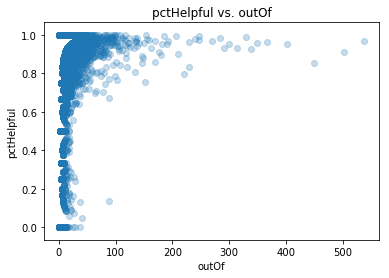

In [88]:
plt.scatter(X_train.outOf, X_train.pctHelpful, alpha=0.25)
plt.title('pctHelpful vs. outOf')
plt.xlabel('outOf')
plt.ylabel('pctHelpful')
plt.show();

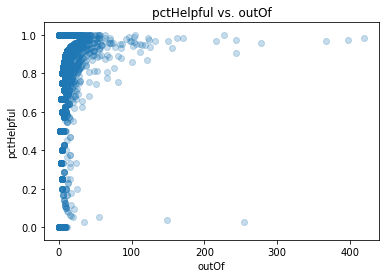

In [89]:
plt.scatter(X_val.outOf, X_val.pctHelpful, alpha=0.25)
plt.title('pctHelpful vs. outOf')
plt.xlabel('outOf')
plt.ylabel('pctHelpful')
plt.show();

### write processed files to csv

In [ ]:
# write files to csv
X_train.to_csv('train.csv', index=False)
X_val.to_csv('val.csv', index=False)
X_test.to_csv('test.csv', index=False)